<table>
  <tr>
    <td><div align="left"><font size="30">Image-based Visual Servo</font></div></td>
    <td><img src="https://github.com/Tobias-Fischer/RVSS2022/blob/main/Robotic_Vision/common/RVSS-logo.png?raw=1" width="400"></td>
  </tr>
</table>

We need to import some modules. We will use the standard `numpy` package to help us with linear algebraic operations on matrices and vectors.

In [37]:
import numpy as np
import math

%matplotlib inline

np.set_printoptions(linewidth=120, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})
from machinevisiontoolbox import Image, CentralCamera
from spatialmath import base, SE3

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D, art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

***
We will define the coordinates of the three vertices of an equilateral triangle, as columns of a matrix

In [9]:
P = np.array([  [-1, 0,            5],
                [ 1, 0,            5],
                [ 0, math.sqrt(3), 5]]).T
P

array([[      -1,        1,        0],
       [       0,        0,    1.732],
       [       5,        5,        5]])

Instantiate a projective camera object, centred at the origin and viewing parallel to the world frame z-axis

In [10]:
camera = CentralCamera.Default()

Now we can project the triangle vertex points to the image plane

In [11]:
p = camera.project_point(P)
p

array([[     340,      660,      500],
       [     500,      500,    777.1]])

the result is a matrix with one column for each image plane point for the world point in the corresponding column  (in units of pixels)

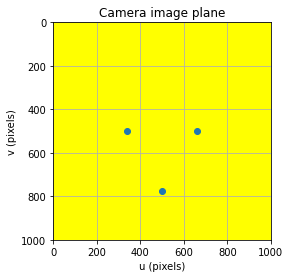

In [12]:
# setup the plot
plt.figure()
ax = plt.gca()
plt.grid(True)
ax.set_aspect('equal')
ax.set_facecolor('yellow')
plt.xlabel('u (pixels)')
plt.ylabel('v (pixels)')
plt.title('Camera image plane')
plt.xlim(0, 1000)
ax.set_ylim(1000, 0)  # inverted y-axis

plt.plot(p[0,:], p[1,:], 'o');


Now, we want the image-plane points to be somewhere else, let's choose the goal image plane coordinates

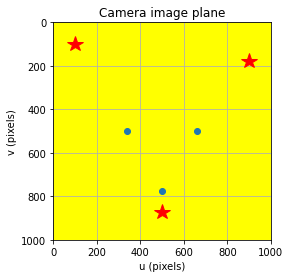

In [13]:
pstar = np.array( [
    [100,   100],
    [900,   180],
    [500,   870] ]).T

plt.figure()
ax = plt.gca()
plt.grid(True)
ax.set_aspect('equal')
ax.set_facecolor('yellow')
plt.xlabel('u (pixels)')
plt.ylabel('v (pixels)')
plt.title('Camera image plane')
plt.xlim(0, 1000)
ax.set_ylim(1000, 0)  # inverted y-axis

plt.plot(p[0,:], p[1,:], 'o');
plt.plot(pstar[0,:], pstar[1,:], 'r*', markersize=16);
plt.show()

The error, between where the vertices are, and where we want them is simply

In [14]:
e = pstar - p
print(e)

[[    -240      240        0]
 [    -400     -320    92.87]]


we can plot the actual image-plane positions, the desired image-plane positions and the error vectors on the one plot

<Figure size 432x288 with 0 Axes>

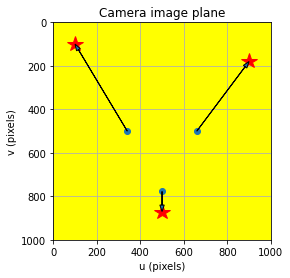

In [15]:
plt.clf()
plt.figure()
ax = plt.gca()
plt.grid(True)
ax.set_aspect('equal')
ax.set_facecolor('yellow')
plt.xlabel('u (pixels)')
plt.ylabel('v (pixels)')
plt.title('Camera image plane')
plt.xlim(0, 1000)
ax.set_ylim(1000, 0)  # inverted y-axis

plt.plot(p[0,:], p[1,:], 'o')
plt.plot(pstar[0,:], pstar[1,:], 'r*', markersize=16)

for a,b in zip(p.T, e.T):
    plt.arrow(a[0], a[1], b[0], b[1], head_width=20, zorder=20, length_includes_head=True)

The image-plane velocity will be some small multiple of these error vectors

In [16]:
pdot_star = 0.01 * e.reshape((-1,1), order='F')  # turn e into a column vector with row-major ordering
pdot_star

array([[    -2.4],
       [      -4],
       [     2.4],
       [    -3.2],
       [       0],
       [  0.9287]])

Now we can create a Jacobian matrix for the 3 points, this is a vertical stack of the $2 \times 6$ Jacobian matrices, resulting in a $6 \times 6$ matrix. `visjac` does this automatically, given N points, it will return a $2N \times 6$ Jacobian matrix.  We do need to provide an estimate of the distance to the points, here that is set to 3m for all the points.  See `Camera.visjac?` for more details.

In [17]:
Jp = camera.visjac_p(p, 3)
print(Jp.round(2))

[[  -266.7        0   -53.33        0     -832        0]
 [       0   -266.7        0      800        0      160]
 [  -266.7        0    53.33        0     -832        0]
 [       0   -266.7        0      800        0     -160]
 [  -266.7        0        0        0     -800    277.1]
 [       0   -266.7    92.38      896        0        0]]


Now we invert the relationship from camera velocity to image plane, to solve for the camera velocity required given the desired image plane velocity.

In [18]:
vcam = np.linalg.inv(Jp) @ pdot_star
vcam

array([[-0.06755],
       [ 0.02512],
       [   0.045],
       [0.003873],
       [ 0.02165],
       [ -0.0025]])

which is the velocity the camera must have in 3D space in order to move the image to be more like that shown with the stars.  The motion is predominantly in the camera x-direction as well as some rotation about the camera's y-axis.

We define an IBVS visual servo control function, this computes the control given the camera pose (the pose attribute of the camera object) and the desired image plane points.

In [64]:
vmax = 0.2  # maximum norm of camera velocity
dt = 1   # time step

def IBVS(camera, P, pstar, lam=1, Z=5):
    p = camera.project_point(P)
    e = pstar - p
    pdot_star = lam * e.flatten(order='F')
    Jp = camera.visjac_p(p, Z)
    
    # limit speed of motion
    vcam = np.linalg.inv(Jp) @ pdot_star
    vn = np.linalg.norm(vcam)
    if vn > vmax:
        vcam = vcam / vn * vmax
    
    # update camera pose, we use matrix exponential to convert velocity screw to SE(3) increment
    camera.pose @= SE3.Delta(vcam * dt) 
    
    return vcam, np.linalg.norm(e), p

We need to call this function repeatedly to see how the camera pose evolves over time.  

Sorry, too hard to make cool graphics that work on CoLab :(

In [69]:
# the camera starts at the origin, with its optical axis parallel to the world z-axis
camera = CentralCamera.Default()
P = np.array([  [-1, 0,            5],
                [ 1, 0,            5],
                [ 0, math.sqrt(3), 5]]).T
pstar = np.array( [
                  [100,   100],
                  [900,   180],
                  [500,   870] ]).T

# Set parameters for pose updating

Z = 5       # use fixed value of Z
lam = 0.2   # scalar gain

pose_history = SE3.Empty()
enorm_history = []
p_history = []
for i in range(50):
    vel, enorm, p = vservo(camera, P, pstar, lam=lam)
    # print(enorm, camera.pose.strline(), vel.T)

    # save results for later
    pose_history.append(camera.pose)
    enorm_history.append(enorm)
    p_history.append(p)

OK, that wasn't very exciting, let's see what happened.

Firstly, we will see how the points moved on the image plane of the camera (which is moving)

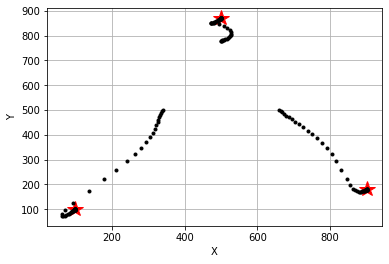

In [75]:
plt.figure()
plt.plot(pstar[0,:], pstar[1,:], 'r*', markersize=16);
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
for p in p_history:
    plt.plot(p[0, :], p[1, :], 'k.', markersize=6)

Here's how the camera moved.  We see that the camera has moved upward (positive z-axis motion)

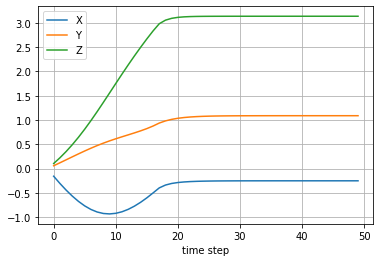

In [71]:
plt.plot(pose_history.t)
plt.legend(list("XYZ"))
plt.xlabel('time step')
plt.grid(True)

Finally, here's the error norm, which has converged to zero.  It is monotonic, but not exponential decay.

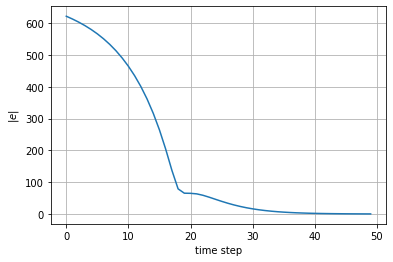

In [76]:
plt.plot(enorm_history)
plt.xlabel('time step')
plt.ylabel('$\|e\|$')
plt.grid(True)

You can experiment with this in various ways:
* change the gain
* change the initial position of the camera
* servo to more than 3 points. In this case the Jacobian will be non-square so you will have to use the pseudo inverse
* change the assumed distance of the target